# Machine Translation

## Translation from the Telugu Language to English

in the following code i have loaded the data. then do the preprocessing and EDA. then i have created few visualizations. then i have tokenized and prprocessed the input to give it to the model. then i have implimented the models(m

## imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import evaluate
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from transformers import (
    MarianTokenizer, MarianMTModel,
    MBart50Tokenizer, MBartForConditionalGeneration,
    Seq2SeqTrainer, Seq2SeqTrainingArguments,
    DataCollatorForSeq2Seq
)

In [ ]:
# Load and clean data
df = pd.read_csv("equal_5_translated.csv")
df["text"] = df["text"].str.strip()
df["text_te"] = df["text_te"].str.strip()
df = df.drop_duplicates(subset=["text", "text_te"]).dropna(subset=["text", "text_te"]).reset_index(drop=True)

print("Cleaned dataset size:", df.shape[0])
print(df[["text_te", "text"]].head())

Cleaned dataset size: 3529
                                             text_te  \
0  ప్రారంభంలో, పైపు రాక్ లో శీతలీకరణ ద్రవ పైపు ఎం...   
1  వేడి కవాటంలో చట్రం వేడి తనిఖీ ఆపరేషన్ ప్రారంభి...   
2  మొదట వేడి బేలో చట్రం వేడి తనిఖీ యొక్క పని పూర్...   
3  మొదటి స్టోరేజ్ షెల్ఫ్ లో డాష్బోర్డ్ ప్యానెల్ త...   
4  యొక్క పైపు రాక్ లో శీతలీకరణ పైపు ఎంచుకోండి తో ...   

                                                text  
0  Initially, pick the coolant pipe in the pipe r...  
1  Start the operation with inspect the chassis w...  
2  First complete the task of inspect the chassis...  
3  Proceed by first fetch the dashboard panel in ...  
4  Let’s start with pick the coolant pipe in the ...  


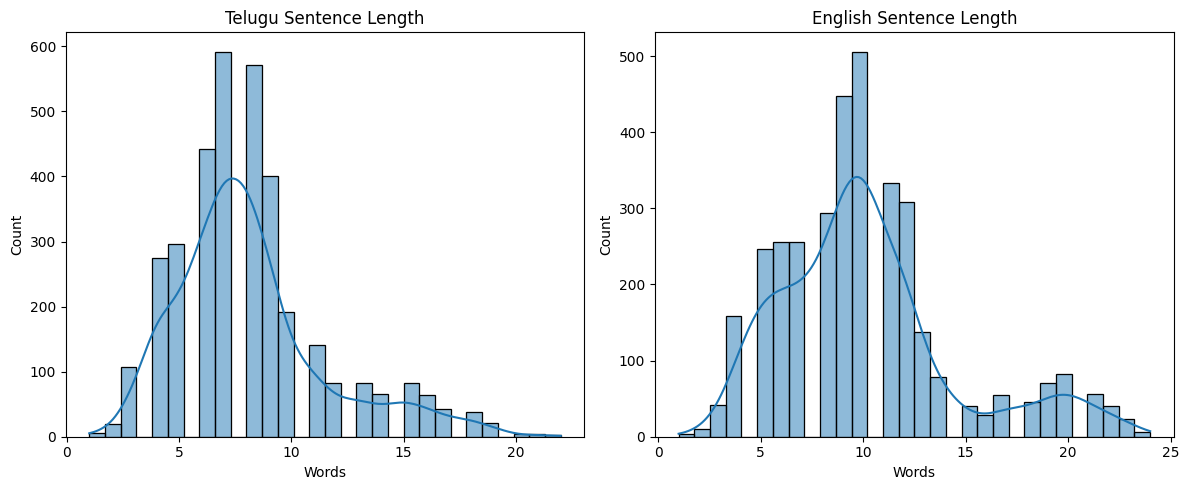

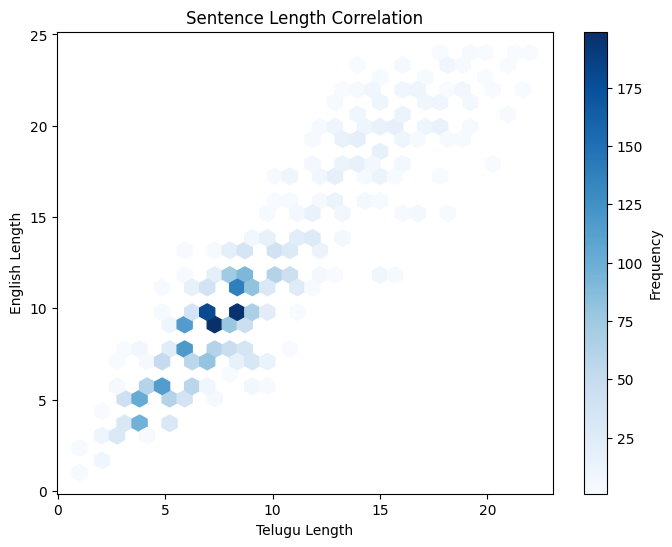

In [ ]:
# Sentence length EDA
df["telugu_len"] = df["text_te"].apply(lambda x: len(x.split()))
df["english_len"] = df["text"].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df["telugu_len"], bins=30, kde=True)
plt.title("Telugu Sentence Length")
plt.xlabel("Words")

plt.subplot(1, 2, 2)
sns.histplot(df["english_len"], bins=30, kde=True)
plt.title("English Sentence Length")
plt.xlabel("Words")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.hexbin(df["telugu_len"], df["english_len"], gridsize=30, cmap="Blues", mincnt=1)
plt.colorbar(label='Frequency')
plt.xlabel("Telugu Length")
plt.ylabel("English Length")
plt.title("Sentence Length Correlation")
plt.show()


In [ ]:
# Split dataset
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "validation": Dataset.from_pandas(val_df),
    "test": Dataset.from_pandas(test_df),
})


In [ ]:

# Post-processing glossary
# glossary = {
#     "keep": "install", "put": "place", "fix": "install",
#     "mount": "install", "move": "navigate", "go": "navigate",
#     "attach": "install", "apply": "paint",
# }
glossary = {
    "keep": "install",
    "put": "place",
    "fix": "install",
    "set": "install",
    "mount": "install",
    "attach": "install",
    "tight": "tighten",
    "loose": "loosen",
    "apply": "paint",
    "connect": "install",
    "disconnect": "remove",
    "remove": "detach",
    "take": "pick",
    "pick up": "pick",
    "place down": "place",
    "move": "navigate",
    "go": "navigate",
    "walk": "navigate",
    "transfer": "move",
    "bring": "move",
    "carry": "move",
    "slide": "adjust",
    "shift": "adjust",
    "adjust": "align",
    "align": "align",
    "inspect": "check",
    "check": "verify",
    "verify": "verify",
    "clean": "wipe",
    "wipe": "clean",
    "tight the": "tighten the",  # malformed forms
    "loose the": "loosen the",
}

# phrase_replacements = {
#     "engine area": "engine bay", "dashboard fitting": "dashboard panel",
#     "navigation to": "navigate to", "painting": "paint",
#     "tight the": "tighten the", "pick up": "pick",
# }

phrase_replacements = {
    "engine area": "engine bay",
    "battery zone": "battery compartment",
    "dashboard fitting": "dashboard panel",
    "chassis fitting": "chassis panel",
    "steering zone": "steering column",
    "navigation to": "navigate to",
    "painting": "paint",
    "pick up": "pick",
    "put down": "place",
    "tight the": "tighten the",
    "loose the": "loosen the",
    "move towards": "navigate to",
    "go to": "navigate to",
    "clean up": "clean",
    "check the status of": "verify",
    "remove from": "detach from",
    "bring to": "move to",
    "align the parts": "align components",
    "install onto": "install on",
    "attached to": "installed on",
    "tighten with": "tighten using",
    "loosen with": "loosen using",
    "transfer to": "move to",
    "open the door": "unlock door",
    "close the door": "lock door",
    "camera check": "image capture",
}



In [ ]:

def post_process(sentence, glossary, replacements):
    s = sentence.lower()
    for word, rep in glossary.items():
        s = re.sub(rf'\b{word}\b', rep, s)
    for phrase, rep in replacements.items():
        s = s.replace(phrase, rep)
    return s[0].upper() + s[1:]

def preprocess_function(batch, tokenizer, src_lang=None, tgt_lang=None):
    if src_lang and tgt_lang:
        tokenizer.src_lang = src_lang
        tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(batch["text_te"], padding="max_length", truncation=True, max_length=128)
    labels = tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)
    inputs["labels"] = labels["input_ids"]
    return inputs

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
def train_and_evaluate(model_name, tokenizer_cls, model_cls, configs, dataset, src_lang=None, tgt_lang=None, model_tag=""):
    tokenizer = tokenizer_cls.from_pretrained(model_name)
    if src_lang and tgt_lang:
        tokenizer.src_lang = src_lang
        tokenizer.tgt_lang = tgt_lang
    # model = model_cls.from_pretrained(model_name)
    model = model_cls.from_pretrained(model_name).to(device)

    bleu = evaluate.load("sacrebleu")
    data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

    tokenized_dataset = dataset.map(
        lambda batch: preprocess_function(batch, tokenizer, src_lang, tgt_lang),
        batched=True
    )

    scores = {}
    for i, cfg in enumerate(configs):
        print(f"\nTraining {model_tag} - {cfg['name']}")

        # model = model_cls.from_pretrained(model_name)
        model = model_cls.from_pretrained(model_name).to(device)

        training_args = Seq2SeqTrainingArguments(
            output_dir=f"./{model_tag}-run{i+1}",
            per_device_train_batch_size=cfg["batch_size"],
            per_device_eval_batch_size=cfg["batch_size"],
            num_train_epochs=cfg["epochs"],
            learning_rate=cfg["lr"],
            weight_decay=cfg["weight_decay"],
            evaluation_strategy="epoch",
            save_strategy="epoch",
            predict_with_generate=True,
            logging_dir=f"./logs-{model_tag}-{i+1}",
            logging_steps=50,
            save_total_limit=2,
            report_to="none",
            fp16 =True,
        )

        trainer = Seq2SeqTrainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_dataset["train"],
            eval_dataset=tokenized_dataset["validation"],
            tokenizer=tokenizer,
            data_collator=data_collator
        )

        trainer.train()
        predictions = trainer.predict(tokenized_dataset["test"])
        decoded_preds = tokenizer.batch_decode(predictions.predictions, skip_special_tokens=True)
        decoded_labels = tokenizer.batch_decode(predictions.label_ids, skip_special_tokens=True)

        bleu_result = bleu.compute(predictions=decoded_preds, references=[[ref] for ref in decoded_labels])
        scores[cfg["name"]] = bleu_result["score"]

        processed_preds = [post_process(p, glossary, phrase_replacements) for p in decoded_preds]
        final_bleu = bleu.compute(predictions=processed_preds, references=[[ref] for ref in decoded_labels])
        scores[f"{cfg['name']} (Post)"] = final_bleu["score"]

        if cfg["name"] == "Config 2":
            save_path = f"./{model_tag}-best-config2"
            trainer.save_model(save_path)
            tokenizer.save_pretrained(save_path)
            print(f"Best model saved to {save_path}")

    return scores


In [ ]:

def plot_bleu_scores(score_dict, title):
    df_plot = pd.DataFrame({
        "Config": list(score_dict.keys()),
        "BLEU Score": list(score_dict.values())
    })
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_plot, x="Config", y="BLEU Score", palette="viridis")
    plt.title(title)
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--')
    for i, score in enumerate(df_plot["BLEU Score"]):
        plt.text(i, score + 0.5, f"{score:.2f}", ha='center')
    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


Map:   0%|          | 0/2823 [00:00<?, ? examples/s]

Map:   0%|          | 0/353 [00:00<?, ? examples/s]

Map:   0%|          | 0/353 [00:00<?, ? examples/s]


Training marianmt - Config 1


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-76-c5e57c0b186c>:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,0.162400,0.095742
2,0.061100,0.051038
3,0.038000,0.041672
4,0.024900,0.038413
5,0.022400,0.036928


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3353: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512, 'num_beams': 6, 'bad_words_ids': [[64171]]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(



Training marianmt - Config 2


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-76-c5e57c0b186c>:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,0.222900,0.143867
2,0.084700,0.069236
3,0.053400,0.050935
4,0.035200,0.043493
5,0.031800,0.039840
6,0.025400,0.038163
7,0.023300,0.037025
8,0.019900,0.036732


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3353: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512, 'num_beams': 6, 'bad_words_ids': [[64171]]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Best model saved to ./marianmt-best-config2

Training marianmt - Config 3


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-76-c5e57c0b186c>:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,0.736900,0.151525
2,0.104400,0.072299
3,0.060100,0.053830
4,0.043900,0.047096
5,0.042100,0.044969


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3353: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512, 'num_beams': 6, 'bad_words_ids': [[64171]]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


<ipython-input-77-30fcb0361977>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x="Config", y="BLEU Score", palette="viridis")


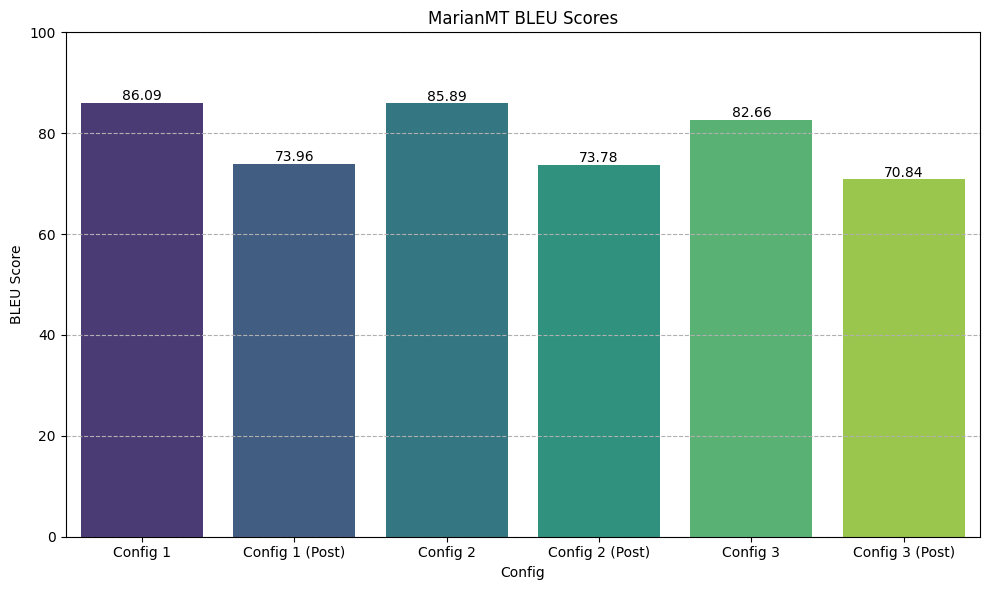

In [ ]:
# Configurations
marian_configs = [
    {"name": "Config 1", "batch_size": 16, "epochs": 5, "lr": 5e-5, "weight_decay": 0.01},
    {"name": "Config 2", "batch_size": 16, "epochs": 8, "lr": 3e-5, "weight_decay": 0.01},
    {"name": "Config 3", "batch_size": 32, "epochs": 5, "lr": 5e-5, "weight_decay": 0.001},
]
# Run MarianMT
marian_scores = train_and_evaluate(
    model_name="Helsinki-NLP/opus-mt-mul-en",
    tokenizer_cls=MarianTokenizer,
    model_cls=MarianMTModel,
    configs=marian_configs,
    dataset=dataset,
    model_tag="marianmt"
)
plot_bleu_scores(marian_scores, "MarianMT BLEU Scores")

Map:   0%|          | 0/2823 [00:00<?, ? examples/s]

Map:   0%|          | 0/353 [00:00<?, ? examples/s]

Map:   0%|          | 0/353 [00:00<?, ? examples/s]


Training mbart50 - Config 1


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-81-b8ed05ee82f7>:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,0.028100,0.021280
2,0.013300,0.016350
3,0.007000,0.013796
4,0.003000,0.014080
5,0.001700,0.014252


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3353: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 200, 'early_stopping': True, 'num_beams': 5}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(



Training mbart50 - Config 2


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-81-b8ed05ee82f7>:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,0.028100,0.021818
2,0.014800,0.017420
3,0.008100,0.014609
4,0.004300,0.014798
5,0.002400,0.014750
6,0.001800,0.014881
7,0.001400,0.015004
8,0.001100,0.015104


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3353: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 200, 'early_stopping': True, 'num_beams': 5}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Best model saved to ./mbart50-best-config2

Training mbart50 - Config 3


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-81-b8ed05ee82f7>:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,0.048000,0.024723
2,0.015600,0.017211
3,0.009100,0.015231
4,0.004400,0.015417
5,0.002700,0.015282
6,0.002000,0.015333


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3353: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 200, 'early_stopping': True, 'num_beams': 5}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


<ipython-input-82-30fcb0361977>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x="Config", y="BLEU Score", palette="viridis")


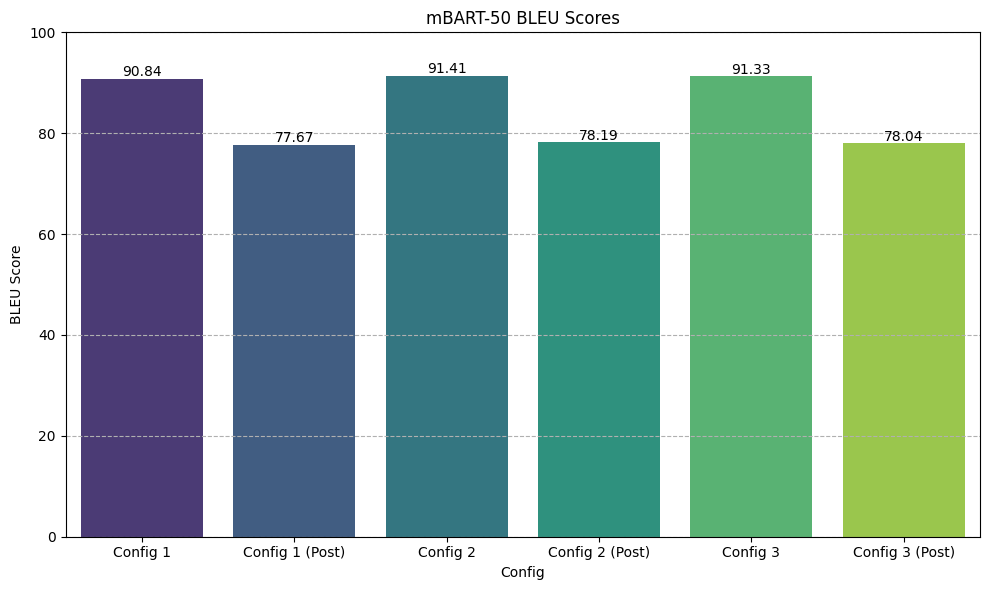

In [ ]:


mbart_configs = [
    {"name": "Config 1", "batch_size": 8, "epochs": 5, "lr": 3e-5, "weight_decay": 0.01},
    {"name": "Config 2", "batch_size": 8, "epochs": 8, "lr": 2e-5, "weight_decay": 0.01},
    {"name": "Config 3", "batch_size": 16, "epochs": 6, "lr": 3e-5, "weight_decay": 0.001},
]

# Run mBART-50
mbart_scores = train_and_evaluate(
    model_name="facebook/mbart-large-50-many-to-many-mmt",
    tokenizer_cls=MBart50Tokenizer,
    model_cls=MBartForConditionalGeneration,
    configs=mbart_configs,
    dataset=dataset,
    src_lang="te_IN",
    tgt_lang="en_XX",
    model_tag="mbart50"
)
plot_bleu_scores(mbart_scores, "mBART-50 BLEU Scores")


In [ ]:
print("Final BLEU Scores for MarianMT:")
print(marian_scores)

print("\nFinal BLEU Scores for mBART-50:")
print(mbart_scores)


Final BLEU Scores for MarianMT:
{'Config 1': 86.08580593864149, 'Config 1 (Post)': 73.96491486129048, 'Config 2': 85.8919168230648, 'Config 2 (Post)': 73.78247415473335, 'Config 3': 82.65934998117815, 'Config 3 (Post)': 70.83929700379494}

Final BLEU Scores for mBART-50:
{'Config 1': 90.83903788196224, 'Config 1 (Post)': 77.67465515154754, 'Config 2': 91.40512555892076, 'Config 2 (Post)': 78.18985070184392, 'Config 3': 91.32958075336435, 'Config 3 (Post)': 78.04280124334538}


In [ ]:
!pip install transformers datasets sacrebleu


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 20.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_m

In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.5 MB/s eta 0:00:00


# Application 2

# Class classification

In [ ]:
# Imports
import pandas as pd
import numpy as np
import random
import torch
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, DataCollatorWithPadding
)
from datasets import Dataset


In [ ]:
# Load the uploaded CSV file
file_path = "/content/dataset_nlp2.csv"
df_1_1= pd.read_csv(file_path)

# Show basic info and first few rows
df_1_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3529 entries, 0 to 3528
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  3529 non-null   int64 
 1   text        3529 non-null   object
 2   class       3529 non-null   object
 3   steps       3529 non-null   object
 4   intent      2818 non-null   object
 5   text_te     3529 non-null   object
dtypes: int64(1), object(5)
memory usage: 165.6+ KB


In [ ]:
df_1_1.head()

,Unnamed: 0,text,class,steps,intent,text_te
0,0,"Initially, pick the coolant pipe in the pipe r...",Planning,"[{'action': 'pick', 'object': 'coolant pipe', ...",NaN,"ప్రారంభంలో, పైపు రాక్ లో శీతలీకరణ ద్రవ పైపు ఎం..."
1,1,Start the operation with inspect the chassis w...,Planning,"[{'action': 'inspect', 'object': 'chassis weld...",NaN,వేడి కవాటంలో చట్రం వేడి తనిఖీ ఆపరేషన్ ప్రారంభి...
2,2,First complete the task of inspect the chassis...,Planning,"[{'action': 'inspect', 'object': 'chassis weld...",NaN,మొదట వేడి బేలో చట్రం వేడి తనిఖీ యొక్క పని పూర్...
3,3,Proceed by first fetch the dashboard panel in ...,Planning,"[{'action': 'fetch', 'object': 'dashboard pane...",NaN,మొదటి స్టోరేజ్ షెల్ఫ్ లో డాష్బోర్డ్ ప్యానెల్ త...
4,4,Let’s start with pick the coolant pipe in the ...,Planning,"[{'action': 'pick', 'object': 'coolant pipe', ...",NaN,యొక్క పైపు రాక్ లో శీతలీకరణ పైపు ఎంచుకోండి తో ...


In [ ]:
df = df_1_1.copy()

In [ ]:
# Normalize class labels
df['class'] = df['class'].replace({'other': 'Other'})
df['class'] = df['class'].astype(str)

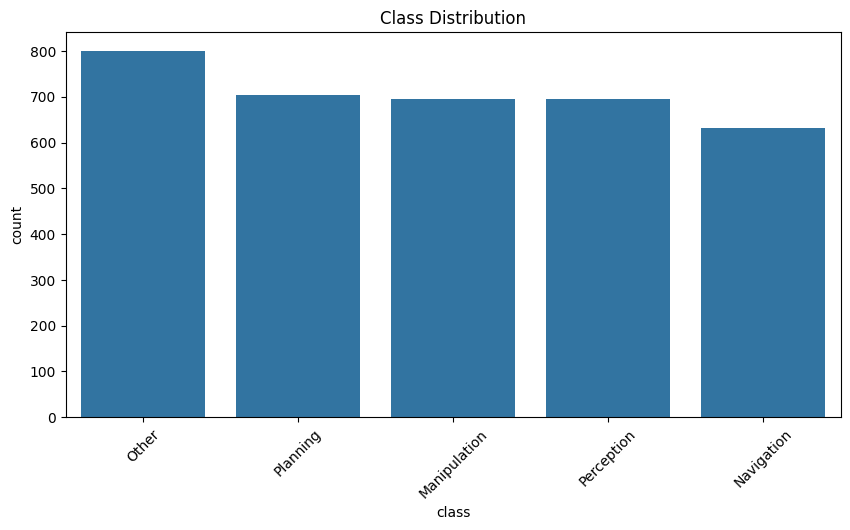

In [ ]:
# Check for missing values
missing_values = df.isnull().sum()

# Plot class distribution
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='class', order=df['class'].value_counts().index)
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.show()

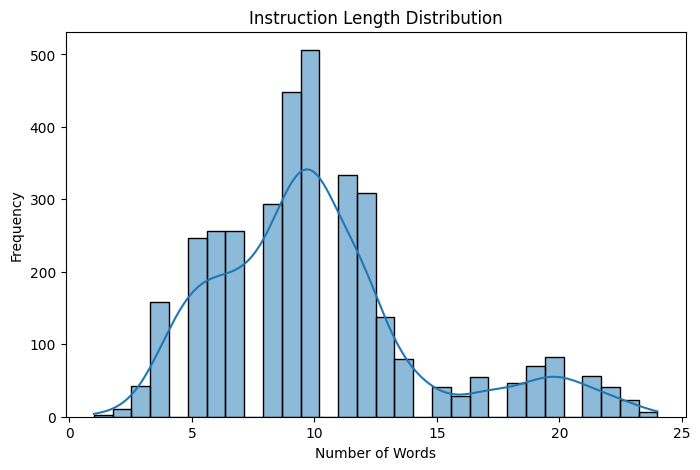

In [ ]:
# Add column with word count
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

# Histogram of word counts
plt.figure(figsize=(8,5))
sns.histplot(df['word_count'], bins=30, kde=True)
plt.title("Instruction Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


In [ ]:
# Encode class labels

le = LabelEncoder()
df['label'] = le.fit_transform(df['class'])

# Drop rows with missing values in 'text'
df_cleaned = df.dropna(subset=['text'])


print(df_cleaned[['text', 'class', 'label']].sample(5))


                                                   text         class  label
325   Please proceed to fitting line and detect the ...    Perception      3
3405                       Who is the CEO of Company16?         Other      2
2868                     Translate Phrase40 to Spanish.         Other      2
746   Step one: fetch the dashboard panel in the sto...  Manipulation      0
299   Begin the sequence with navigate to the dashbo...      Planning      4


In [ ]:
duplicate_counts = df['text'].duplicated().sum()
duplicate_counts

np.int64(0)

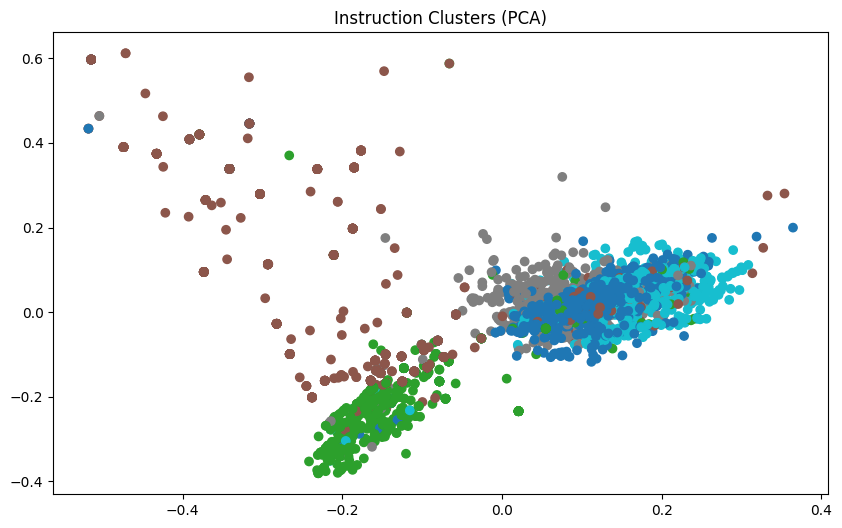

In [ ]:
vec = TfidfVectorizer(max_features=300)
X_vec = vec.fit_transform(df['text'])
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_vec.toarray())

plt.figure(figsize=(10,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=df['label'], cmap='tab10')
plt.title("Instruction Clusters (PCA)")
plt.show()


In [ ]:
# Load and prepare data
df = df.dropna(subset=["text", "class"])
df["class"] = df["class"].replace({'other': 'Other'}).astype(str)

# Encode labels
le = LabelEncoder()
df["label"] = le.fit_transform(df["class"])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["label"], test_size=0.2, stratify=df["label"], random_state=42
)

# -------------------------
# LOGISTIC REGRESSION
# -------------------------
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

log_reg1 = LogisticRegression(max_iter=200)
log_reg1.fit(X_train_tfidf, y_train)
pred1 = log_reg1.predict(X_test_tfidf)
log_f1_1 = classification_report(y_test, pred1, target_names=le.classes_, output_dict=True)['weighted avg']['f1-score']

log_reg2 = LogisticRegression(max_iter=300, C=0.5)
log_reg2.fit(X_train_tfidf, y_train)
pred2 = log_reg2.predict(X_test_tfidf)
log_f1_2 = classification_report(y_test, pred2, target_names=le.classes_, output_dict=True)['weighted avg']['f1-score']

# -------------------------
# NAIVE BAYES
# -------------------------
nb1 = MultinomialNB()
nb1.fit(X_train_tfidf, y_train)
nb_pred1 = nb1.predict(X_test_tfidf)
nb_f1_1 = classification_report(y_test, nb_pred1, target_names=le.classes_, output_dict=True)['weighted avg']['f1-score']

nb2 = MultinomialNB(alpha=0.3)
nb2.fit(X_train_tfidf, y_train)
nb_pred2 = nb2.predict(X_test_tfidf)
nb_f1_2 = classification_report(y_test, nb_pred2, target_names=le.classes_, output_dict=True)['weighted avg']['f1-score']

# -------------------------
# RANDOM FOREST
# -------------------------
count_vectorizer = CountVectorizer(max_features=5000)
X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

rf1 = RandomForestClassifier(n_estimators=100, random_state=42)
rf1.fit(X_train_count, y_train)
rf_pred1 = rf1.predict(X_test_count)
rf_f1_1 = classification_report(y_test, rf_pred1, target_names=le.classes_, output_dict=True)['weighted avg']['f1-score']

rf2 = RandomForestClassifier(n_estimators=300, max_depth=20, random_state=42)
rf2.fit(X_train_count, y_train)
rf_pred2 = rf2.predict(X_test_count)
rf_f1_2 = classification_report(y_test, rf_pred2, target_names=le.classes_, output_dict=True)['weighted avg']['f1-score']

# -------------------------
# TinyBERT
# -------------------------
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["text"], df["label"], test_size=0.2, stratify=df["label"], random_state=42
)

train_dataset = Dataset.from_dict({'text': train_texts.tolist(), 'label': train_labels.tolist()})
val_dataset = Dataset.from_dict({'text': val_texts.tolist(), 'label': val_labels.tolist()})

model_name = "prajjwal1/bert-tiny"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    report = classification_report(labels, preds, target_names=le.classes_, output_dict=True)
    return {
        'accuracy': report['accuracy'],
        'macro_f1': report['macro avg']['f1-score'],
        'weighted_f1': report['weighted avg']['f1-score']
    }

configs = [
    {"name": "Config 1", "lr": 2e-5, "epochs": 6, "batch": 16, "weight_decay": 0.01},
    {"name": "Config 2", "lr": 3e-5, "epochs": 8, "batch": 32, "weight_decay": 0.005},
    {"name": "Config 3", "lr": 1e-5, "epochs": 10, "batch": 16, "weight_decay": 0.0},
]

tinybert_results = {}
best_bert_f1 = 0
best_bert_model = None

for cfg in configs:
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(le.classes_))

    training_args = TrainingArguments(
        output_dir=f"./tinybert-{cfg['name'].lower().replace(' ', '-')}",
        evaluation_strategy="epoch",
        learning_rate=cfg["lr"],
        per_device_train_batch_size=cfg["batch"],
        per_device_eval_batch_size=cfg["batch"],
        num_train_epochs=cfg["epochs"],
        weight_decay=cfg["weight_decay"],
        logging_dir=f"./logs-{cfg['name'].lower().replace(' ', '-')}",
        report_to="none",
        save_strategy="no"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        tokenizer=tokenizer,
        data_collator=data_collator,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
    )

    trainer.train()
    eval_results = trainer.evaluate()
    tinybert_results[cfg["name"]] = eval_results

    if eval_results['eval_weighted_f1'] > best_bert_f1:
        best_bert_f1 = eval_results['eval_weighted_f1']
        best_bert_model = model

# -------------------------
# Model Comparison Summary
# -------------------------
model_scores = {
    "Logistic Regression Config 1": log_f1_1,
    "Logistic Regression Config 2": log_f1_2,
    "Naive Bayes Config 1": nb_f1_1,
    "Naive Bayes Config 2": nb_f1_2,
    "Random Forest Config 1": rf_f1_1,
    "Random Forest Config 2": rf_f1_2,
    "TinyBERT Config 1": tinybert_results["Config 1"]['eval_weighted_f1'],
    "TinyBERT Config 2": tinybert_results["Config 2"]['eval_weighted_f1'],
    "TinyBERT Config 3": tinybert_results["Config 3"]['eval_weighted_f1'],
}

print("\nModel Comparison Summary (Weighted F1):")
for model, score in model_scores.items():
    print(f"{model}: {score:.4f}")

# -------------------------
# Save Best Model
# -------------------------
best_model_name = max(model_scores, key=model_scores.get)
print(f"\nBest Model: {best_model_name}")

if "TinyBERT" in best_model_name:
    best_bert_model.save_pretrained("best_tinybert_model")
    tokenizer.save_pretrained("best_tinybert_model")
else:
    if "Logistic" in best_model_name:
        best_model = log_reg1 if "Config 1" in best_model_name else log_reg2
        joblib.dump(best_model, "best_model.pkl")
        joblib.dump(tfidf_vectorizer, "vectorizer.pkl")
    elif "Naive" in best_model_name:
        best_model = nb1 if "Config 1" in best_model_name else nb2
        joblib.dump(best_model, "best_model.pkl")
        joblib.dump(tfidf_vectorizer, "vectorizer.pkl")
    elif "Random" in best_model_name:
        best_model = rf1 if "Config 1" in best_model_name else rf2
        joblib.dump(best_model, "best_model.pkl")
        joblib.dump(count_vectorizer, "vectorizer.pkl")


Map:   0%|          | 0/2823 [00:00<?, ? examples/s]

Map:   0%|          | 0/706 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-126-e3149c988764>:117: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
1,No log,1.407405,0.558074,0.502434,0.506907
2,No log,1.228206,0.740793,0.730089,0.731467
3,1.374000,1.102379,0.818697,0.817881,0.818298
4,1.374000,1.016588,0.852691,0.853101,0.853001
5,1.374000,0.967421,0.862606,0.863102,0.862907
6,1.065100,0.952728,0.859773,0.860214,0.860027


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-126-e3149c988764>:117: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
1,No log,1.412173,0.637394,0.595729,0.597933
2,No log,1.182020,0.759207,0.758956,0.759726
3,No log,1.011965,0.841360,0.842727,0.842566
4,No log,0.898331,0.871105,0.872005,0.871615
5,No log,0.822919,0.878187,0.878887,0.878446
6,1.161200,0.776165,0.885269,0.885951,0.885583
7,1.161200,0.750772,0.885269,0.885942,0.885569
8,1.161200,0.743113,0.889518,0.890141,0.889736


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-126-e3149c988764>:117: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
1,No log,1.482256,0.623229,0.613951,0.619742
2,No log,1.351681,0.736544,0.730199,0.731097
3,1.455500,1.240280,0.777620,0.775058,0.775532
4,1.455500,1.153481,0.798867,0.797475,0.797735
5,1.455500,1.081812,0.834278,0.835322,0.835250
6,1.192200,1.028895,0.835694,0.836861,0.836863
7,1.192200,0.989967,0.856941,0.857788,0.857603
8,1.192200,0.963728,0.861190,0.861845,0.861676
9,1.052000,0.948008,0.861190,0.861845,0.861676
10,1.052000,0.942942,0.862606,0.863271,0.863092



Model Comparison Summary (Weighted F1):
Logistic Regression Config 1: 0.9051
Logistic Regression Config 2: 0.9037
Naive Bayes Config 1: 0.8881
Naive Bayes Config 2: 0.8882
Random Forest Config 1: 0.9009
Random Forest Config 2: 0.8910
TinyBERT Config 1: 0.8600
TinyBERT Config 2: 0.8897
TinyBERT Config 3: 0.8631

Best Model: Logistic Regression Config 1


In [ ]:
df = df.dropna(subset=["text", "class"])
df["class"] = df["class"].astype(str)

# Label encode classes
le = LabelEncoder()
df["label"] = le.fit_transform(df["class"])

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["label"], test_size=0.2, stratify=df["label"], random_state=42
)

# ---------------------------------------------
# LOGISTIC REGRESSION
# ---------------------------------------------
print("Logistic Regression:")

# Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Config 1
log_reg1 = LogisticRegression(max_iter=200)
log_reg1.fit(X_train_tfidf, y_train)
pred1 = log_reg1.predict(X_test_tfidf)
report1 = classification_report(y_test, pred1, target_names=le.classes_)
print("\nConfig 1:\n", report1)

# Config 2
log_reg2 = LogisticRegression(max_iter=300, C=0.5)
log_reg2.fit(X_train_tfidf, y_train)
pred2 = log_reg2.predict(X_test_tfidf)
report2 = classification_report(y_test, pred2, target_names=le.classes_)
print("\nConfig 2:\n", report2)

# ---------------------------------------------
# NAIVE BAYES
# ---------------------------------------------
print("\n Naive Bayes:")

# Config 1
nb1 = MultinomialNB()
nb1.fit(X_train_tfidf, y_train)
nb_pred1 = nb1.predict(X_test_tfidf)
nb_report1 = classification_report(y_test, nb_pred1, target_names=le.classes_)
print("\nConfig 1:\n", nb_report1)

# Config 2
nb2 = MultinomialNB(alpha=0.3)
nb2.fit(X_train_tfidf, y_train)
nb_pred2 = nb2.predict(X_test_tfidf)
nb_report2 = classification_report(y_test, nb_pred2, target_names=le.classes_)
print("\nConfig 2:\n", nb_report2)

# ---------------------------------------------
# RANDOM FOREST
# ---------------------------------------------
print("\nRandom Forest:")

# Vectorization
count_vectorizer = CountVectorizer(max_features=5000)
X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

# Config 1
rf1 = RandomForestClassifier(n_estimators=100, random_state=42)
rf1.fit(X_train_count, y_train)
rf_pred1 = rf1.predict(X_test_count)
rf_report1 = classification_report(y_test, rf_pred1, target_names=le.classes_)
print("\nConfig 1:\n", rf_report1)

# Config 2
rf2 = RandomForestClassifier(n_estimators=300, max_depth=20, random_state=42)
rf2.fit(X_train_count, y_train)
rf_pred2 = rf2.predict(X_test_count)
rf_report2 = classification_report(y_test, rf_pred2, target_names=le.classes_)
print("\nConfig 2:\n", rf_report2)


Logistic Regression:

Config 1:
               precision    recall  f1-score   support

Manipulation       0.90      0.90      0.90       139
  Navigation       0.93      0.90      0.92       127
       Other       0.91      0.88      0.90       160
  Perception       0.91      0.91      0.91       139
    Planning       0.88      0.94      0.91       141

    accuracy                           0.91       706
   macro avg       0.91      0.91      0.91       706
weighted avg       0.91      0.91      0.91       706


Config 2:
               precision    recall  f1-score   support

Manipulation       0.90      0.89      0.90       139
  Navigation       0.93      0.90      0.92       127
       Other       0.91      0.88      0.90       160
  Perception       0.90      0.91      0.91       139
    Planning       0.88      0.94      0.91       141

    accuracy                           0.90       706
   macro avg       0.90      0.90      0.90       706
weighted avg       0.90      0.9

In [ ]:

df['class'] = df['class'].replace({'other': 'Other'}).astype(str)

# Label encode
le = LabelEncoder()
df['label'] = le.fit_transform(df['class'])

# Split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'], df['label'], test_size=0.2, stratify=df['label'], random_state=42
)

# Datasets
train_dataset = Dataset.from_dict({'text': train_texts.tolist(), 'label': train_labels.tolist()})
val_dataset = Dataset.from_dict({'text': val_texts.tolist(), 'label': val_labels.tolist()})

# Tokenizer
model_name = "prajjwal1/bert-tiny"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True)

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Evaluation metric
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    report = classification_report(labels, preds, target_names=le.classes_, output_dict=True)
    return {
        'accuracy': report['accuracy'],
        'macro_f1': report['macro avg']['f1-score'],
        'weighted_f1': report['weighted avg']['f1-score']
    }

# Define three configurations
configs = [
    {"name": "Config 1", "lr": 2e-5, "epochs": 6, "batch": 16, "weight_decay": 0.01},
    {"name": "Config 2", "lr": 3e-5, "epochs": 8, "batch": 32, "weight_decay": 0.005},
    {"name": "Config 3", "lr": 1e-5, "epochs": 10, "batch": 16, "weight_decay": 0.0},
]

# Train and evaluate each config
results = {}

for i, cfg in enumerate(configs):
    print(f"\nStarting {cfg['name']}...")

    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(le.classes_))

    training_args = TrainingArguments(
        output_dir=f"./tinybert-{cfg['name'].lower().replace(' ', '-')}",
        evaluation_strategy="epoch",
        learning_rate=cfg["lr"],
        per_device_train_batch_size=cfg["batch"],
        per_device_eval_batch_size=cfg["batch"],
        num_train_epochs=cfg["epochs"],
        weight_decay=cfg["weight_decay"],
        logging_dir=f"./logs-{cfg['name'].lower().replace(' ', '-')}",
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        tokenizer=tokenizer,
        data_collator=data_collator,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
    )

    trainer.train()
    eval_results = trainer.evaluate()
    results[cfg["name"]] = eval_results

# Print summary
print("\nTinyBERT Config Results Summary:")
for name, res in results.items():
    print(f"{name} - Accuracy: {res['eval_accuracy']:.4f}, Macro F1: {res['eval_macro_f1']:.4f}, Weighted F1: {res['eval_weighted_f1']:.4f}")


Map:   0%|          | 0/2823 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/706 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Starting Config 1...


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-112-7b4e4ae9f7ce>:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
1,No log,1.411780,0.580737,0.538469,0.542442
2,No log,1.236305,0.729462,0.712922,0.714567
3,1.376200,1.102825,0.814448,0.811573,0.811988
4,1.376200,1.015658,0.852691,0.852698,0.852617
5,1.376200,0.968047,0.859773,0.860012,0.859863
6,1.066600,0.952335,0.861190,0.861473,0.861310


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Starting Config 2...


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-112-7b4e4ae9f7ce>:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
1,No log,1.407957,0.634561,0.599130,0.600813
2,No log,1.187667,0.783286,0.784303,0.784628
3,No log,1.012216,0.835694,0.837045,0.836967
4,No log,0.895348,0.872521,0.873463,0.873020
5,No log,0.820801,0.883853,0.884558,0.884132
6,1.158500,0.775281,0.888102,0.888732,0.888346
7,1.158500,0.748447,0.886686,0.887347,0.886969
8,1.158500,0.740664,0.886686,0.887347,0.886969


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Starting Config 3...


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-112-7b4e4ae9f7ce>:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
1,No log,1.481658,0.611898,0.599054,0.604969
2,No log,1.349749,0.753541,0.751243,0.752179
3,1.454700,1.238370,0.803116,0.803400,0.803637
4,1.454700,1.151082,0.804533,0.804389,0.804633
5,1.454700,1.081203,0.834278,0.835360,0.835295
6,1.191700,1.028699,0.837110,0.838199,0.838185
7,1.191700,0.990820,0.851275,0.852150,0.852012
8,1.191700,0.964201,0.861190,0.862030,0.861895
9,1.053500,0.948988,0.862606,0.863382,0.863226
10,1.053500,0.943911,0.864023,0.864732,0.864555



TinyBERT Config Results Summary:
Config 1 - Accuracy: 0.8612, Macro F1: 0.8615, Weighted F1: 0.8613
Config 2 - Accuracy: 0.8867, Macro F1: 0.8873, Weighted F1: 0.8870
Config 3 - Accuracy: 0.8640, Macro F1: 0.8647, Weighted F1: 0.8646


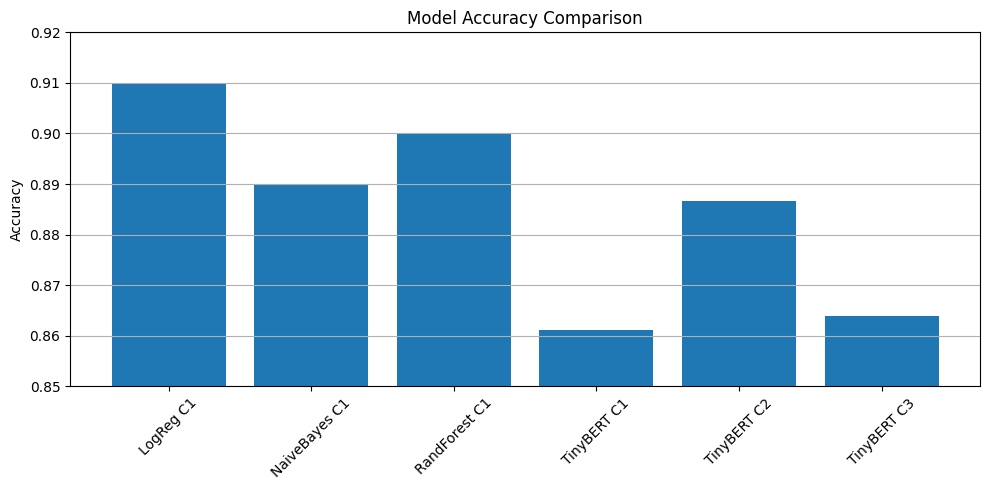

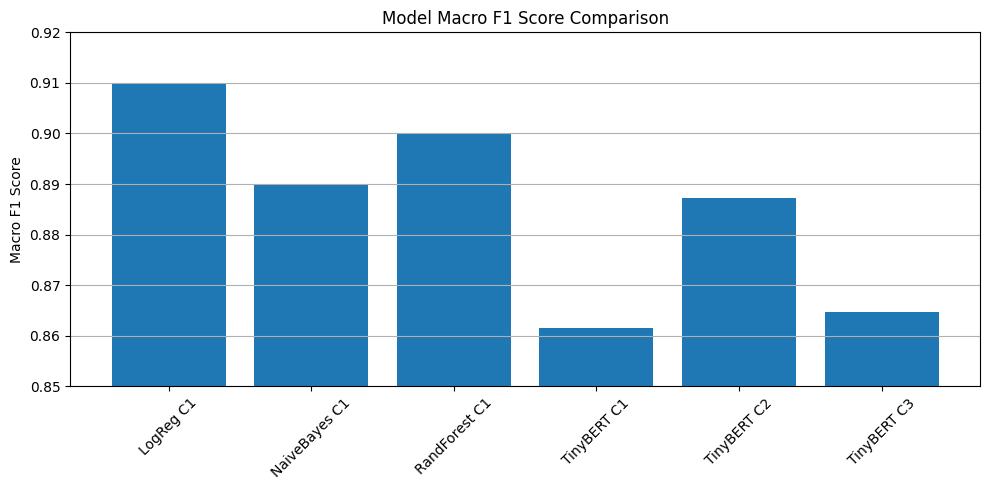

In [ ]:
import matplotlib.pyplot as plt

# Model names and configurations
models = [
    "LogReg C1", "NaiveBayes C1", "RandForest C1",
    "TinyBERT C1", "TinyBERT C2", "TinyBERT C3"
]

# Accuracy scores
accuracy = [0.91, 0.89, 0.90, 0.8612, 0.8867, 0.8640]

# Macro F1 scores
macro_f1 = [0.91, 0.89, 0.90, 0.8615, 0.8873, 0.8647]

# Plotting accuracy
plt.figure(figsize=(10, 5))
plt.bar(models, accuracy)
plt.ylim(0.85, 0.92)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Plotting macro F1
plt.figure(figsize=(10, 5))
plt.bar(models, macro_f1)
plt.ylim(0.85, 0.92)
plt.title("Model Macro F1 Score Comparison")
plt.ylabel("Macro F1 Score")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


# Semantic parsing
# text to steps ( robot commands)

In [ ]:
!pip install -q transformers datasets evaluate

# Core Python libraries
import pandas as pd
import numpy as np
import ast
import random
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch
import torch

# Hugging Face Transformers and Datasets
from datasets import Dataset
import evaluate
from transformers import (
    T5Tokenizer, T5ForConditionalGeneration,
    MBartForConditionalGeneration, MBart50Tokenizer,
    BartTokenizer, BartForConditionalGeneration,
    Trainer, TrainingArguments
)

# For model saving/loading
import joblib


In [ ]:
# Reload the dataset
file_path = "/content/equal_5_translated.csv"
df = pd.read_csv(file_path)




# EDA

In [ ]:
# Attempt to parse all 'steps' entries and track success or failure
def is_valid_json_format(x):
    try:
        parsed = ast.literal_eval(x)
        return isinstance(parsed, list)
    except Exception:
        return False

df['json_parsed'] = df['steps'].apply(is_valid_json_format)

# Summarize how many were parsed correctly
valid_json_count = df['json_parsed'].sum()
invalid_json_count = len(df) - valid_json_count

# Show rows with invalid JSON
invalid_json_df = df[~df['json_parsed']]

valid_json_count, invalid_json_count


(np.int64(3529), np.int64(0))

## from above code output we can tell that there is no invalid formating

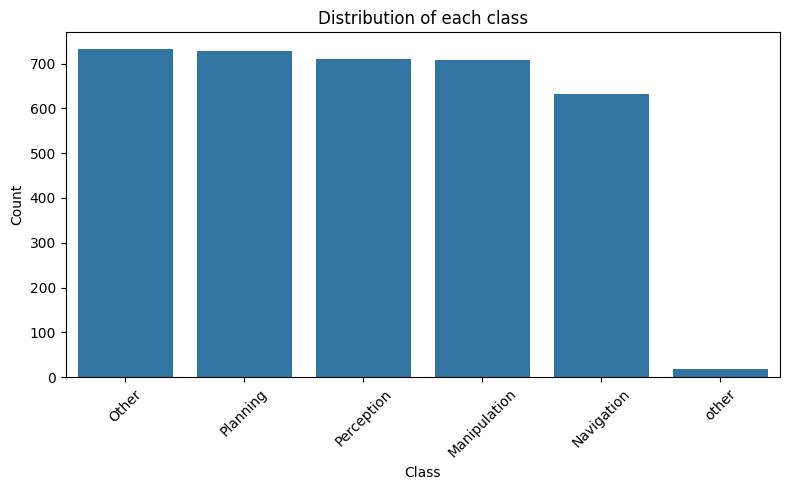

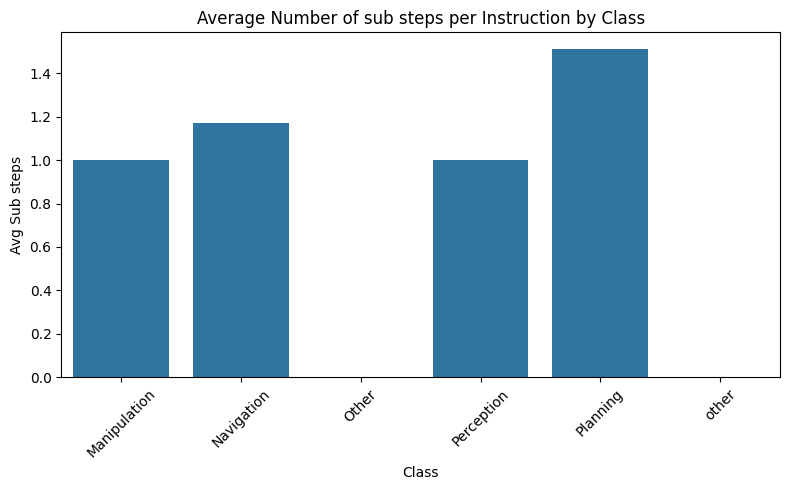

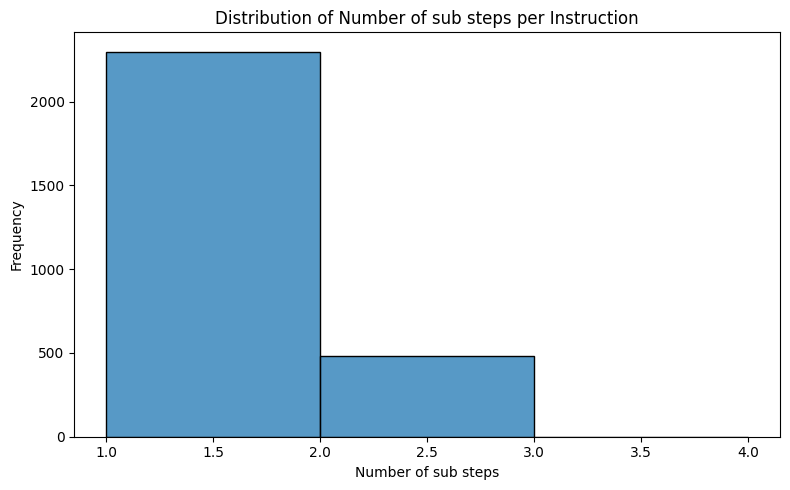

total number of empty steps in the dataset: 751


In [ ]:
df['parsed_steps'] = df['steps'].apply(lambda x: ast.literal_eval(x) if is_valid_json_format(x) else [])

df['num_actions'] = df['parsed_steps'].apply(lambda steps: len(steps))
df['has_steps'] = df['num_actions'] > 0

# Summary statistics
class_counts = df['class'].value_counts()
actions_per_class = df.groupby('class')['num_actions'].mean()
empty_steps_count = len(df[~df['has_steps']])

# Plot: Number of samples per class
plt.figure(figsize=(8, 5))
sns.countplot(x='class', data=df, order=class_counts.index)
plt.title('Distribution of each class')
plt.ylabel('Count')
plt.xlabel('Class')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot: Average number of actions per instruction per class
plt.figure(figsize=(8, 5))
sns.barplot(x=actions_per_class.index, y=actions_per_class.values)
plt.title('Average Number of sub steps per Instruction by Class')
plt.ylabel('Avg Sub steps')
plt.xlabel('Class')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot: Distribution of number of actions
plt.figure(figsize=(8, 5))
sns.histplot(df['num_actions'], bins=range(1, df['num_actions'].max()+2), kde=False)
plt.title('Distribution of Number of sub steps per Instruction')
plt.xlabel('Number of sub steps')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Display summary statistics in table form
summary_df = pd.DataFrame({
    'Class': class_counts.index,
    'Count': class_counts.values,
    'Avg Actions': actions_per_class.values
})


print(f'total number of empty steps in the dataset: {empty_steps_count}')


based on the visualizations we can come to a conclusion that each class has around 700 samples and each sample has 1-3 sub steps.

In [ ]:
summary_df

,Class,Count,Avg Actions
0,Other,733,1.000000
1,Planning,729,1.169572
2,Perception,711,0.000000
3,Manipulation,707,1.000000
4,Navigation,631,1.513032
5,other,18,0.000000


# End of EDA

# Preprocessing

In [ ]:
import re


preprocessed_df = df.copy()



def preprocess_text(text):
    if not isinstance(text, str):
        return text
    # Lowercase
    text = text.lower()
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove excessive punctuation (except essential ones like '.', ',' etc.)
    text = re.sub(r'[^\w\s.,-]', '', text)
    return text

preprocessed_df['clean_text'] = preprocessed_df['text'].apply(preprocess_text)



# Normalize and clean step dictionaries
def clean_step_format(steps, cls):
    try:
        step_list = ast.literal_eval(steps)
        if not isinstance(step_list, list):
            return []
        cleaned_steps = []
        for step in step_list:
            if not isinstance(step, dict):
                continue
            # Strip and lowercase keys and values
            cleaned = {k.strip().lower(): str(v).strip().lower() for k, v in step.items()}
            # Type normalization for value fields
            if cls == "Navigation" and "value" in cleaned:
                try:
                    cleaned["value"] = float(cleaned["value"])
                except ValueError:
                    cleaned["value"] = None
            cleaned_steps.append(cleaned)
        return cleaned_steps
    except Exception:
        return []

preprocessed_df['clean_steps'] = preprocessed_df.apply(
    lambda row: clean_step_format(row['steps'], row['class']), axis=1
)

# Check if cleaned_steps is still valid
preprocessed_df['clean_num_actions'] = preprocessed_df['clean_steps'].apply(lambda x: len(x) if isinstance(x, list) else 0)


preprocessed_df['clean_num_actions'].value_counts().sort_index()


,count
clean_num_actions,
0,751
1,2298
2,479
3,1


# Preprocessing end

Map:   0%|          | 0/2222 [00:00<?, ? examples/s]

Map:   0%|          | 0/556 [00:00<?, ? examples/s]


--- Training Config A ---


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-24-3d21483c7e98>:83: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.175600,0.003925
2,0.004900,0.002619
3,0.003000,0.002341


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].



--- Training Config B ---


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-24-3d21483c7e98>:83: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.465400,0.009868
2,0.012900,0.004394
3,0.007300,0.003239
4,0.005100,0.002854
5,0.004200,0.002733


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].



--- Training Config C ---


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-24-3d21483c7e98>:83: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.897700,0.170384
2,0.131100,0.031220
3,0.048200,0.017566
4,0.031300,0.012624
5,0.023600,0.010074
6,0.020000,0.008676
7,0.017300,0.007615
8,0.015500,0.007025
9,0.014400,0.006646
10,0.014100,0.006514


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


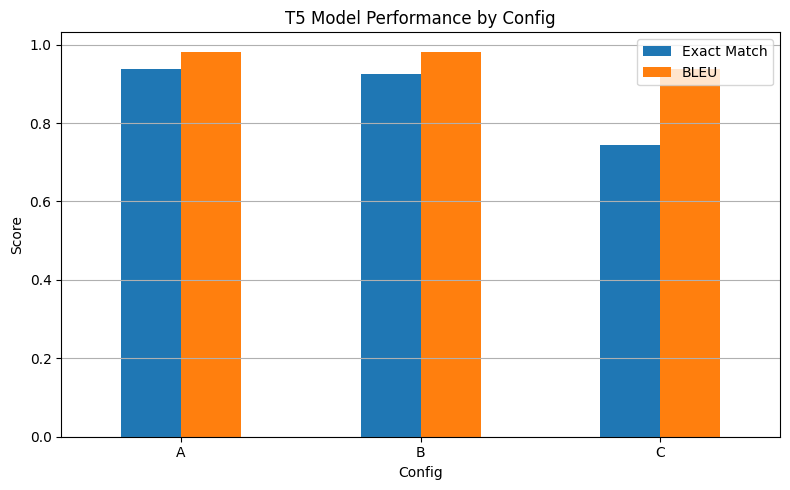


Final Results:
   Config  Exact Match      BLEU
0      A     0.937050  0.982232
1      B     0.924460  0.980419
2      C     0.742806  0.939002


In [ ]:
# Convert clean_steps to string format for T5
def flatten_steps(step_list):
    if not isinstance(step_list, list) or len(step_list) == 0:
        return ""
    step_strs = []
    for step in step_list:
        if isinstance(step, dict):
            parts = [f"{k}:{v}" for k, v in step.items()]
            step_strs.append(" | ".join(parts))
    return " || ".join(step_strs)

preprocessed_df['flattened_steps'] = preprocessed_df['clean_steps'].apply(flatten_steps)

# Filter empty outputs (Other class)
df_filtered = preprocessed_df[preprocessed_df['flattened_steps'].str.strip() != ""]

# Train-test split
df_filtered = df_filtered.sample(frac=1, random_state=42).reset_index(drop=True)
split_idx = int(0.8 * len(df_filtered))
train_df = df_filtered[:split_idx]
test_df = df_filtered[split_idx:]

# Convert to Hugging Face Datasets
dataset_train = Dataset.from_pandas(train_df[['clean_text', 'flattened_steps']])
dataset_test = Dataset.from_pandas(test_df[['clean_text', 'flattened_steps']])

# Tokenization
tokenizer = T5Tokenizer.from_pretrained("t5-small")

max_input_length = 128
max_target_length = 256

def preprocess_function(examples):
    model_inputs = tokenizer(examples["clean_text"], max_length=max_input_length, truncation=True, padding="max_length")
    labels = tokenizer(examples["flattened_steps"], max_length=max_target_length, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

encoded_train = dataset_train.map(preprocess_function, batched=True)
encoded_test = dataset_test.map(preprocess_function, batched=True)

# Training (modified to save best model)
def train_model(config_id, learning_rate, batch_size, num_train_epochs):
  model = T5ForConditionalGeneration.from_pretrained("t5-small")
  training_args = TrainingArguments(
      output_dir=f"./results_t5_config_{config_id}",
      evaluation_strategy="epoch",
      save_strategy="epoch",
      save_total_limit=1,
      load_best_model_at_end=True,
      metric_for_best_model="eval_loss",
      greater_is_better=False,
      learning_rate=learning_rate,
      per_device_train_batch_size=batch_size,
      per_device_eval_batch_size=batch_size,
      num_train_epochs=num_train_epochs,
      weight_decay=0.01,
      logging_dir=f"./logs_t5_config_{config_id}",
      logging_strategy="epoch",
      report_to="none",
      )
  trainer = Trainer(
      model=model,
      args=training_args,
      train_dataset=encoded_train,
      eval_dataset=encoded_test,
      tokenizer=tokenizer,
      )
  trainer.train()

  save_dir = f"./best_t5_model_config_{config_id}"
  trainer.model.save_pretrained(save_dir)
  tokenizer.save_pretrained(save_dir)
  return trainer, trainer.model


# Evaluation
bleu = evaluate.load("bleu")

def evaluate_model(model, tokenizer, test_df, max_input_length=128):
    inputs = tokenizer(test_df['clean_text'].tolist(), return_tensors="pt", padding=True, truncation=True, max_length=max_input_length)
    # outputs = model.generate(input_ids=inputs.input_ids, attention_mask=inputs.attention_mask, max_new_tokens=256)
    device = model.device
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model.generate(**inputs, max_new_tokens=256)


    preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    references = test_df['flattened_steps'].tolist()

    exact_matches = sum([1 for p, r in zip(preds, references) if p.strip() == r.strip()])
    exact_match_acc = exact_matches / len(preds)

    bleu_score = bleu.compute(predictions=preds, references=[[r] for r in references])['bleu']

    return exact_match_acc, bleu_score

# Run Experiments with 3 Configurations
results = []
configs = [
    {"id": "A", "lr": 5e-4, "batch_size": 8, "epochs": 3},
    {"id": "B", "lr": 3e-4, "batch_size": 16, "epochs": 5},
    {"id": "C", "lr": 1e-4, "batch_size": 32, "epochs": 10},
]

for cfg in configs:
    print(f"\n--- Training Config {cfg['id']} ---")
    trainer, model = train_model(cfg['id'], cfg['lr'], cfg['batch_size'], cfg['epochs'])
    exact_acc, bleu_score = evaluate_model(model, tokenizer, test_df)
    results.append({"Config": cfg['id'], "Exact Match": exact_acc, "BLEU": bleu_score})

# Visualization

result_df = pd.DataFrame(results)
result_df.set_index("Config").plot(kind="bar", figsize=(8,5), title="T5 Model Performance by Config")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

print("\nFinal Results:\n", result_df)


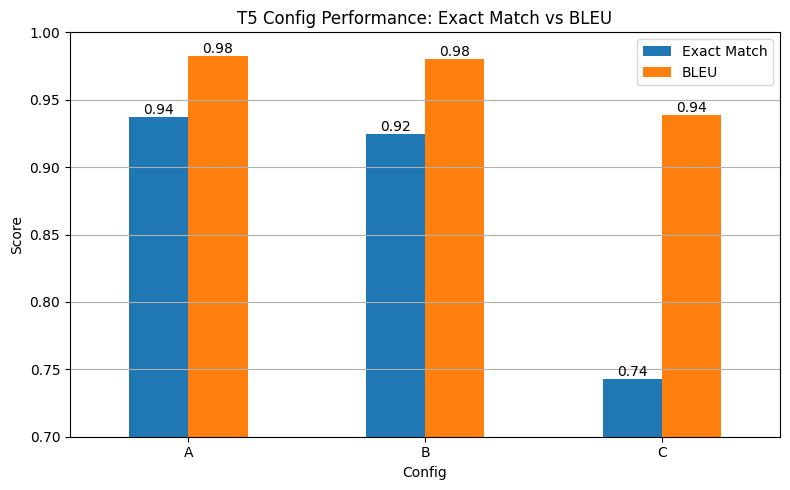

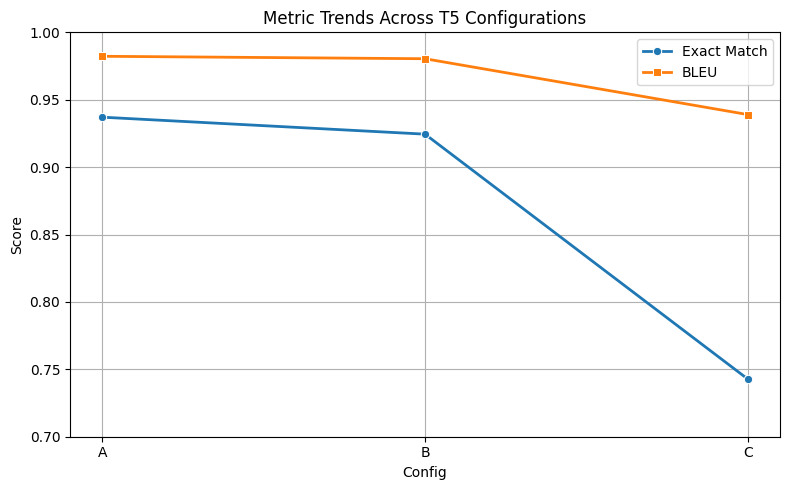

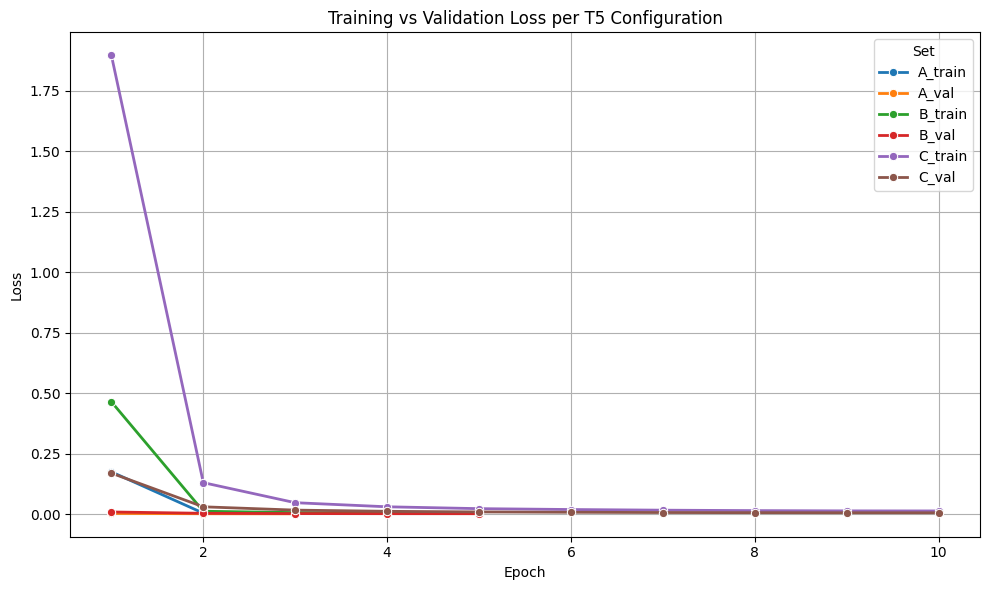

In [ ]:
# Updated result data
result_df = pd.DataFrame({
    "Config": ["A", "B", "C"],
    "Exact Match": [0.937050, 0.924460, 0.742806],
    "BLEU": [0.982232, 0.980419, 0.939002]
})

# bar plot with annotations
plt.figure(figsize=(8, 5))
ax = result_df.set_index("Config")[["Exact Match", "BLEU"]].plot(kind="bar", ax=plt.gca())
plt.title("T5 Config Performance: Exact Match vs BLEU")
plt.ylabel("Score")
plt.ylim(0.7, 1.0)
plt.xticks(rotation=0)
plt.grid(axis='y')

# Add text labels
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Improved line plot with markers and style
plt.figure(figsize=(8, 5))
sns.lineplot(x="Config", y="Exact Match", data=result_df, marker="o", label="Exact Match", linewidth=2)
sns.lineplot(x="Config", y="BLEU", data=result_df, marker="s", label="BLEU", linewidth=2)
plt.title("Metric Trends Across T5 Configurations")
plt.ylabel("Score")
plt.ylim(0.7, 1.0)
plt.grid(True)
plt.tight_layout()
plt.show()

# Updated loss plot
train_val_losses = {
    "Epoch": list(range(1, 11)),
    "A_train": [0.1756, 0.0049, 0.0030] + [None]*7,
    "A_val": [0.003925, 0.002619, 0.002341] + [None]*7,
    "B_train": [0.4654, 0.0129, 0.0073, 0.0051, 0.0042] + [None]*5,
    "B_val": [0.009868, 0.004394, 0.003239, 0.002854, 0.002733] + [None]*5,
    "C_train": [1.8977, 0.1311, 0.0482, 0.0313, 0.0236, 0.0200, 0.0173, 0.0155, 0.0144, 0.0141],
    "C_val": [0.170384, 0.03122, 0.017566, 0.012624, 0.010074, 0.008676, 0.007615, 0.007025, 0.006646, 0.006514]
}
loss_df = pd.DataFrame(train_val_losses)

# Melt and label
melted_loss_df = pd.melt(loss_df, id_vars=["Epoch"], var_name="Set", value_name="Loss")
plt.figure(figsize=(10, 6))
sns.lineplot(data=melted_loss_df, x="Epoch", y="Loss", hue="Set", marker="o", linewidth=2)
plt.title("Training vs Validation Loss per T5 Configuration")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

Map:   0%|          | 0/2222 [00:00<?, ? examples/s]

Map:   0%|          | 0/556 [00:00<?, ? examples/s]


--- Training Config A ---


model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-30-46a0edee09bf>:83: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.122800,0.003001
2,0.002900,0.002299
3,0.001300,0.002225


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3353: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].



--- Training Config B ---


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-30-46a0edee09bf>:83: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,3.332900,0.041034
2,0.017500,0.003479
3,0.003500,0.002528
4,0.002300,0.002434
5,0.001800,0.002369


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3353: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].



--- Training Config C ---


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-30-46a0edee09bf>:83: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,9.088200,4.246514
2,3.937000,2.456063
3,2.418300,1.330832
4,1.357500,0.621662
5,0.679500,0.272003
6,0.328700,0.127222
7,0.169500,0.068391
8,0.101000,0.043697
9,0.071300,0.033535
10,0.059400,0.030706


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3353: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


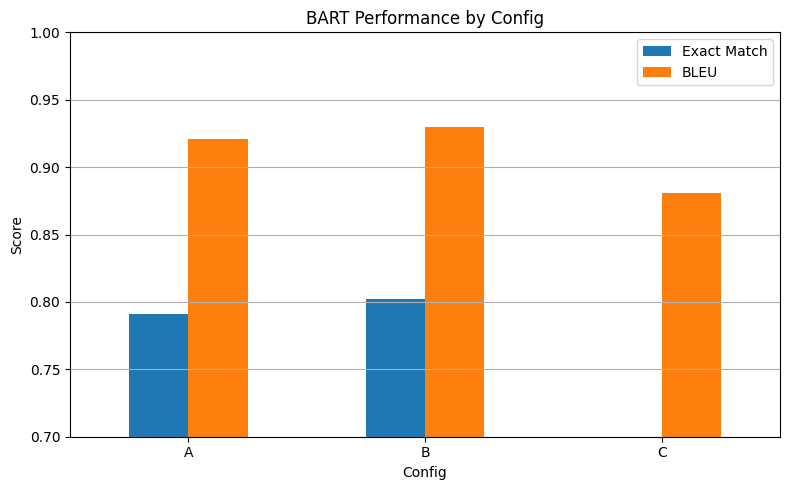


Final Evaluation Results:
   Config  Exact Match      BLEU
0      A     0.791367  0.920652
1      B     0.802158  0.929810
2      C     0.694245  0.880519


In [ ]:
# Flatten steps into structured strings
FIELDS_BY_CLASS = {
    "Navigation": ["action", "value", "unit"],
    "Manipulation": ["action", "object", "location"],
    "Planning": ["action", "object", "location"],
    "Perception": ["action", "target", "location"],
    "Other": []
}

def flatten_steps(row):
    steps = row['clean_steps']
    cls = row['class']
    if not isinstance(steps, list) or len(steps) == 0:
        return ""
    step_strs = []
    for step in steps:
        fields = FIELDS_BY_CLASS.get(cls, [])
        parts = [f"{k}:{step.get(k, '')}" for k in fields if k in step]
        if parts:
            step_strs.append(" | ".join(parts))
    return " || ".join(step_strs)

preprocessed_df['flattened_steps'] = preprocessed_df.apply(flatten_steps, axis=1)
filtered_df = preprocessed_df[preprocessed_df['flattened_steps'].str.strip() != ""]

# Train-test split and dataset conversion
filtered_df = filtered_df.sample(frac=1, random_state=42).reset_index(drop=True)
split_idx = int(0.8 * len(filtered_df))
train_df = filtered_df[:split_idx]
test_df = filtered_df[split_idx:]

train_ds = Dataset.from_pandas(train_df[['clean_text', 'flattened_steps']])
test_ds = Dataset.from_pandas(test_df[['clean_text', 'flattened_steps']])

# Tokenization
tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
max_input_length = 128
max_target_length = 256

def preprocess(example):
    model_inputs = tokenizer(example['clean_text'], max_length=max_input_length, padding="max_length", truncation=True)
    labels = tokenizer(example['flattened_steps'], max_length=max_target_length, padding="max_length", truncation=True)
    model_inputs['labels'] = labels['input_ids']
    return model_inputs

train_ds = train_ds.map(preprocess, batched=True)
test_ds = test_ds.map(preprocess, batched=True)

# Training function
def train_bart_model(config_id, learning_rate, batch_size, num_train_epochs):
    model = BartForConditionalGeneration.from_pretrained("facebook/bart-base")

    training_args = TrainingArguments(
        output_dir=f"./bart_results_{config_id}",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=num_train_epochs,
        weight_decay=0.01,
        logging_dir=f"./bart_logs_{config_id}",
        logging_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=test_ds,
        tokenizer=tokenizer
    )

    trainer.train()
    model.save_pretrained(f"./best_bart_model_{config_id}")
    tokenizer.save_pretrained(f"./best_bart_model_{config_id}")
    return trainer, model

# Evaluation
def evaluate_bart(model):
    bleu = evaluate.load("bleu")
    model.eval()
    inputs = tokenizer(test_df['clean_text'].tolist(), return_tensors="pt", padding=True, truncation=True, max_length=128)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    model.to(model.device)
    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=256)
    preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    refs = test_df['flattened_steps'].tolist()
    exact = sum([1 for p, r in zip(preds, refs) if p.strip() == r.strip()]) / len(refs)
    bleu_score = bleu.compute(predictions=preds, references=[[r] for r in refs])['bleu']
    return exact, bleu_score


results = []
configs = [
    {"id": "A", "lr": 5e-5, "batch_size": 8, "epochs": 3},
    {"id": "B", "lr": 3e-5, "batch_size": 16, "epochs": 5},
    {"id": "C", "lr": 1e-5, "batch_size": 32, "epochs": 10},
]

for cfg in configs:
    print(f"\n--- Training Config {cfg['id']} ---")
    trainer, model = train_bart_model(cfg['id'], cfg['lr'], cfg['batch_size'], cfg['epochs'])
    exact, bleu = evaluate_bart(model)
    results.append({"Config": cfg['id'], "Exact Match": exact, "BLEU": bleu})

# Visualize results
results_df = pd.DataFrame(results)
results_df.set_index("Config")[["Exact Match", "BLEU"]].plot(kind="bar", figsize=(8, 5), title="BART Performance by Config")
plt.ylabel("Score")
plt.ylim(0.7, 1.0)
plt.grid(axis='y')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nFinal Evaluation Results:\n", results_df)


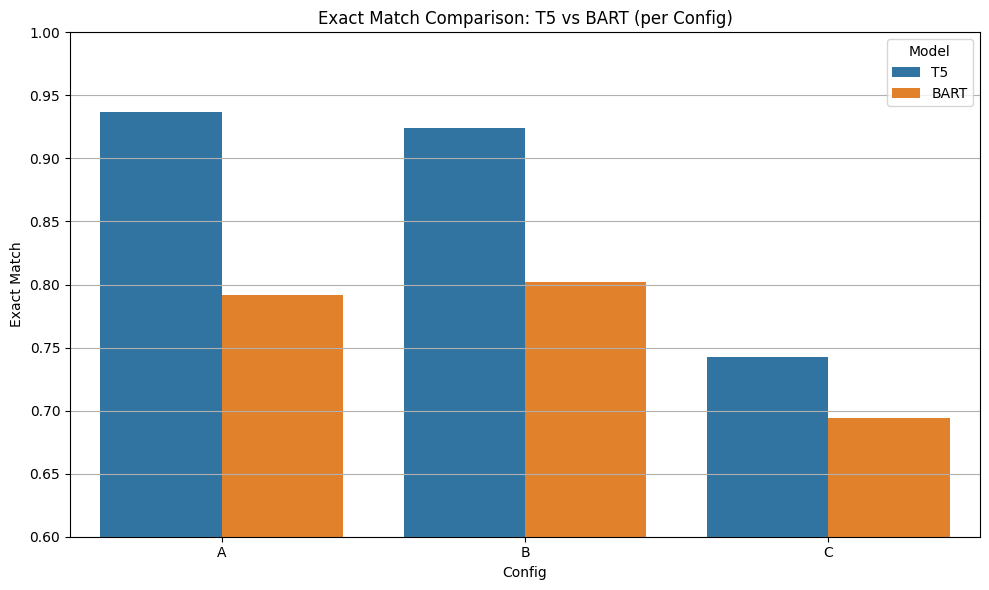

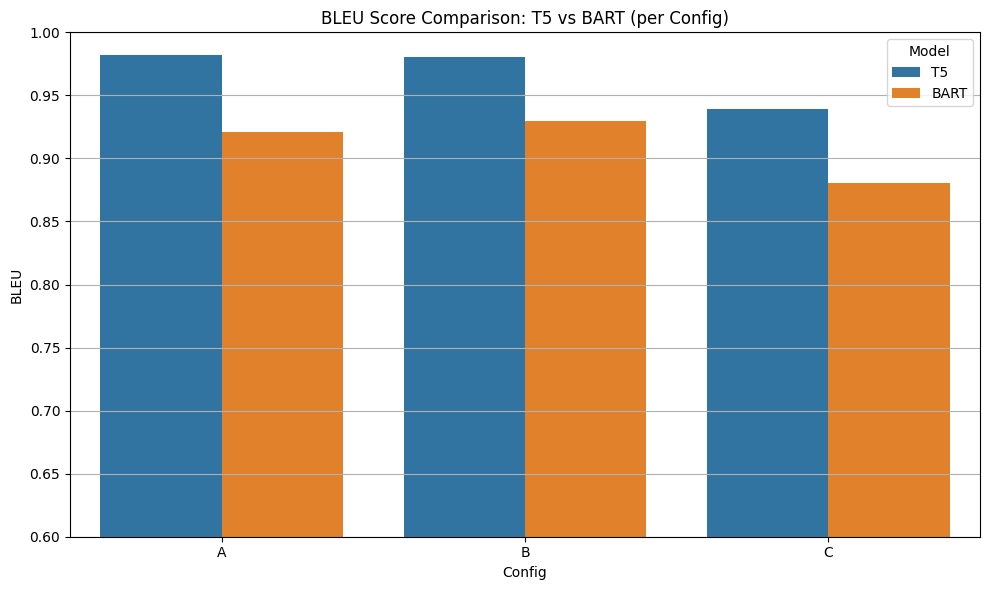

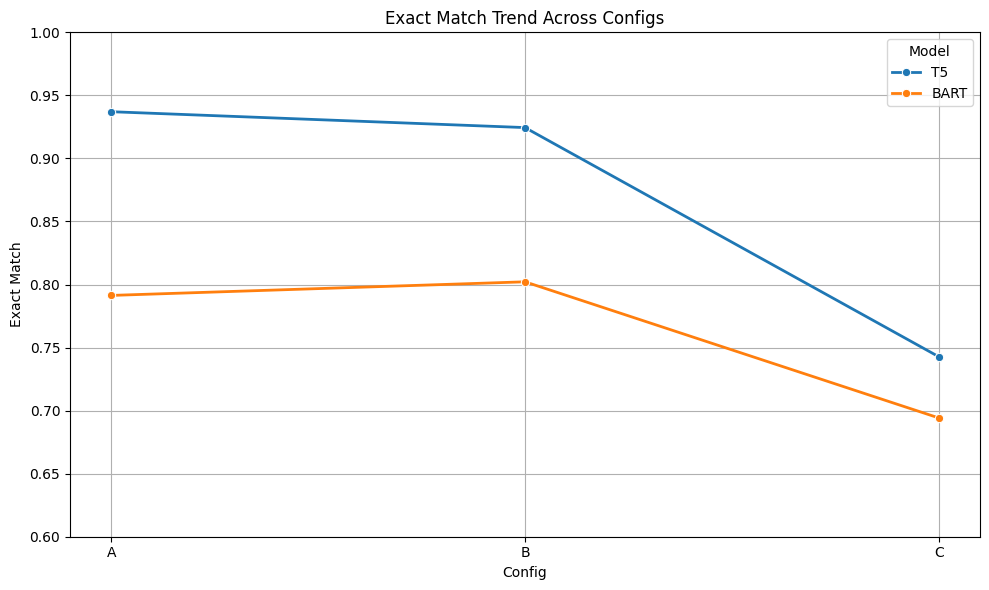

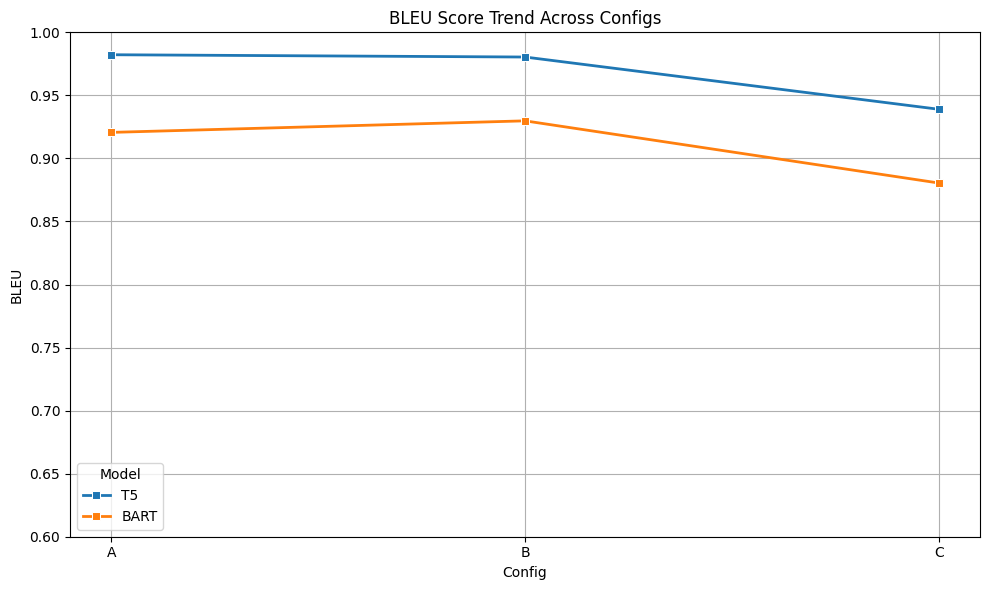

In [ ]:
# T5 results
t5_df = pd.DataFrame({
    "Model": ["T5"] * 3,
    "Config": ["A", "B", "C"],
    "Exact Match": [0.937050, 0.924460, 0.742806],
    "BLEU": [0.982232, 0.980419, 0.939002]
})

# BART results
bart_df = pd.DataFrame({
    "Model": ["BART"] * 3,
    "Config": ["A", "B", "C"],
    "Exact Match": [0.791367, 0.802158, 0.694245],
    "BLEU": [0.920652, 0.929810, 0.880519]
})

# Combine for comparison
combined_df = pd.concat([t5_df, bart_df], ignore_index=True)

# Bar plot: Exact Match by Config per Model
plt.figure(figsize=(10, 6))
sns.barplot(data=combined_df, x="Config", y="Exact Match", hue="Model")
plt.title("Exact Match Comparison: T5 vs BART (per Config)")
plt.ylim(0.6, 1.0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Bar plot: BLEU by Config per Model
plt.figure(figsize=(10, 6))
sns.barplot(data=combined_df, x="Config", y="BLEU", hue="Model")
plt.title("BLEU Score Comparison: T5 vs BART (per Config)")
plt.ylim(0.6, 1.0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Line plot: Exact Match trend
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_df, x="Config", y="Exact Match", hue="Model", marker="o", linewidth=2)
plt.title("Exact Match Trend Across Configs")
plt.ylim(0.6, 1.0)
plt.grid(True)
plt.tight_layout()
plt.show()

# Line plot: BLEU trend
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_df, x="Config", y="BLEU", hue="Model", marker="s", linewidth=2)
plt.title("BLEU Score Trend Across Configs")
plt.ylim(0.6, 1.0)
plt.grid(True)
plt.tight_layout()
plt.show()


## T5 is best for giving  precise structured output

In [ ]:
from huggingface_hub import login
login()


In [ ]:

model = T5ForConditionalGeneration.from_pretrained("best_t5_model_config_A")
tokenizer = T5Tokenizer.from_pretrained("best_t5_model_config_A")

model.push_to_hub("kcpreddy/best-t5-semantic-parser")
tokenizer.push_to_hub("kcpreddy/best-t5-semantic-parser")


model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/kcpreddy/best-t5-semantic-parser/commit/1761217dbc4a31d9103787dfafea3b4d528fdd42', commit_message='Upload tokenizer', commit_description='', oid='1761217dbc4a31d9103787dfafea3b4d528fdd42', pr_url=None, repo_url=RepoUrl('https://huggingface.co/kcpreddy/best-t5-semantic-parser', endpoint='https://huggingface.co', repo_type='model', repo_id='kcpreddy/best-t5-semantic-parser'), pr_revision=None, pr_num=None)

In [ ]:
pip install gradio


  Using cached gradio-5.24.0-py3-none-any.whl.metadata (16 kB)
  Using cached aiofiles-24.1.0-py3-none-any.whl.metadata (10 kB)
  Using cached fastapi-0.115.12-py3-none-any.whl.metadata (27 kB)
  Using cached ffmpy-0.5.0-py3-none-any.whl.metadata (3.0 kB)
  Using cached gradio_client-1.8.0-py3-none-any.whl.metadata (7.1 kB)
  Using cached groovy-0.1.2-py3-none-any.whl.metadata (6.1 kB)
  Using cached safehttpx-0.1.6-py3-none-any.whl.metadata (4.2 kB)
  Using cached starlette-0.46.1-py3-none-any.whl.metadata (6.2 kB)
Using cached gradio-5.24.0-py3-none-any.whl (46.9 MB)
Using cached gradio_client-1.8.0-py3-none-any.whl (322 kB)
Using cached aiofiles-24.1.0-py3-none-any.whl (15 kB)
Using cached fastapi-0.115.12-py3-none-any.whl (95 kB)
Using cached groovy-0.1.2-py3-none-any.whl (14 kB)
Using cached safehttpx-0.1.6-py3-none-any.whl (8.7 kB)
Using cached starlette-0.46.1-py3-none-any.whl (71 kB)
Using cached ffmpy-0.5.0-py3-none-any.whl (6.0 kB)


In [ ]:
import gradio as gr

# Load Translation Model (mbart50-best-config2)
mbart_model = MBartForConditionalGeneration.from_pretrained("mbart50-best-config2")
mbart_tokenizer = MBart50Tokenizer.from_pretrained("mbart50-best-config2")
mbart_tokenizer.src_lang = "te_IN"

# Load Classification Model (best_model.pkl)
clf_model = joblib.load("best_model.pkl")
vectorizer = joblib.load("vectorizer.pkl")

# Load Semantic Parsing Model (best_t5_model_config_A)
t5_model = T5ForConditionalGeneration.from_pretrained("best_t5_model_config_A")
t5_tokenizer = T5Tokenizer.from_pretrained("best_t5_model_config_A")


def translate_telugu_to_english(text):
    inputs = mbart_tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    generated_tokens = mbart_model.generate(**inputs, forced_bos_token_id=mbart_tokenizer.lang_code_to_id["en_XX"])
    return mbart_tokenizer.decode(generated_tokens[0], skip_special_tokens=True)

def classify_text(text):
    features = vectorizer.transform([text])
    predicted_class = clf_model.predict(features)[0]
    return predicted_class

def parse_semantics(text):
    input_ids = t5_tokenizer.encode(text, return_tensors="pt", max_length=128, truncation=True)
    outputs = t5_model.generate(input_ids, max_length=128)
    return t5_tokenizer.decode(outputs[0], skip_special_tokens=True)


def process_text(language, text):
    if language == "Telugu":
        english_text = translate_telugu_to_english(text)
    else:
        english_text = text

    predicted_class = classify_text(english_text)
    parsed_output = parse_semantics(english_text)

    return english_text, predicted_class, parsed_output



iface = gr.Interface(
    fn=process_text,
    inputs=[
        gr.Radio(["Telugu", "English"], label="Input Language"),
        gr.Textbox(lines=3, placeholder="Enter your instruction here...", label="Input Text")
    ],
    outputs=[
        gr.Textbox(label="English Translation"),
        gr.Textbox(label="Predicted Class"),
        gr.Textbox(label="Parsed Steps (JSON)")
    ],
    title="Telugu/English Instruction to Robot Action Parser",
    description="Choose Telugu or English input. The system will translate (if needed), classify the instruction, and output parsed robot steps."
)

iface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6b3f401690dc6fb237.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
